# Setting up dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sliceduot.sliced_barycenter import compute_barycenter_grid_MD_unbalanced

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Gaussians


In [2]:
def gauss(X, center, std):
    return np.exp(-((X-center)**2).sum(1)/std)

mode = 3
step = 200
x = np.linspace(0,1,step)
y = np.linspace(0,1,step)

xx, yy = np.meshgrid(x,y)
grid = np.c_[xx.ravel(), yy.ravel()]
Xgrid= torch.from_numpy(grid).to(device) 

if mode==2:
    center1 = np.array([0.2,0.2]).reshape(1,-1)
    center2 = np.array([0.8,0.8]).reshape(1,-1)

    f1 = gauss(grid,center1,.01)+1e-12
    f2 = gauss(grid,center2,.03)+1e-12
elif mode == 3:
    center1 = np.array([0.5,0.5]).reshape(1,-1)
    center_noise = np.array([0.1,0.1]).reshape(1,-1)
    center2 = np.array([0.8,0.8]).reshape(1,-1)

    f1 = gauss(grid,center1,.01)+gauss(grid,center_noise,.003)+1e-12
    f2 = gauss(grid,center2,.005)+1e-12

f1=f1/f1.sum()
f2=f2/f2.sum()

full_data = torch.from_numpy(np.vstack((f1,f2))).to(device)

# Set default values of barycenter computation

In [3]:
bar_iter = 500
lr_bar=1e-1
fw_iter = 25
num_proj=16

weights1=[0.75, 0.25]
weights2=[0.5, 0.5]
weights3=[0.25, 0.75]

# Testing the SOT barycenter computation (Backprop mode)

In [4]:
rho1= None
mode = 'backprop'

barycenter1 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights1,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter2 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights2,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter3 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights3,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

Objective value 0.03172667324542999: 100%|██████████| 500/500 [00:27<00:00, 18.18it/s] 


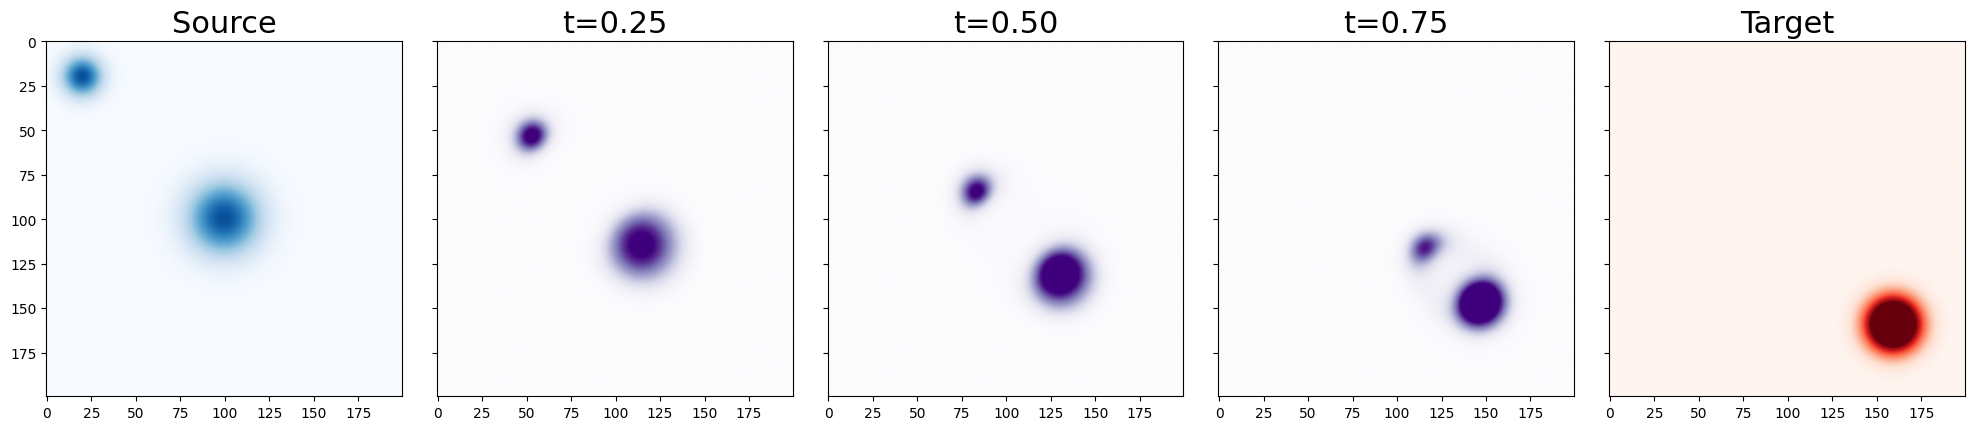

In [5]:
vmin=0
vmax=7e-4
fs=22

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,4), sharey=True)
ax1.imshow(f1.reshape((step,step)),cmap='Blues',vmin=vmin,vmax=vmax)
ax1.set_title('Source',fontsize=fs)
ax5.imshow(f2.reshape((step,step)),cmap='Reds',vmin=vmin,vmax=vmax)
ax5.set_title('Target',fontsize=fs)
ax2.imshow(barycenter1.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax2.set_title('t=0.25',fontsize=fs)
ax3.imshow(barycenter2.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax3.set_title('t=0.50',fontsize=fs)
ax4.imshow(barycenter3.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax4.set_title('t=0.75',fontsize=fs)
#plt.savefig('img/bary_SW.pdf')
plt.tight_layout()
plt.savefig('img/bary_SW.pdf', bbox_inches='tight')
plt.show()  

# USOT barycenter
$\rho_1$ is large, output should be close to SOT barycenter

**Backprop mode**  gives better outputs and is kept as default.

In [6]:
rho1= 100.
mode = 'backprop'

barycenter1 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights1,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter2 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights2,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter3 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights3,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)


Objective value 0.036037422716617584: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


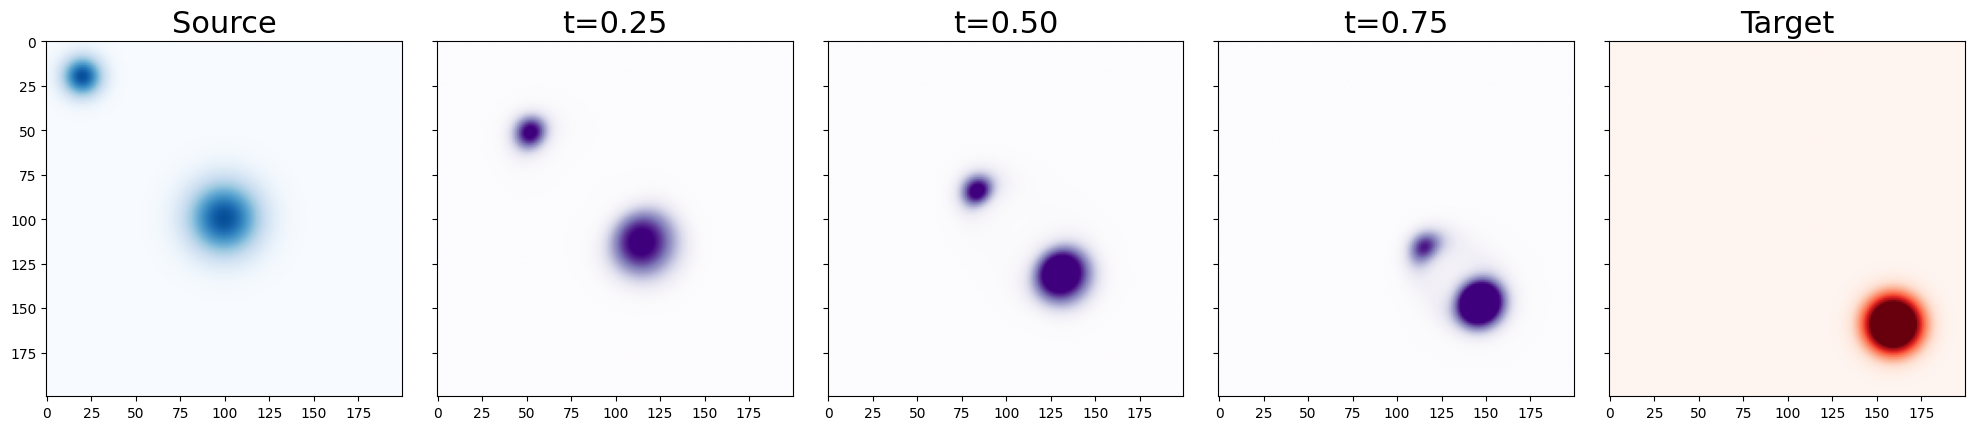

In [7]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,4), sharey=True)
ax1.imshow(f1.reshape((step,step)),cmap='Blues',vmin=vmin,vmax=vmax)
ax1.set_title('Source',fontsize=fs)
ax5.imshow(f2.reshape((step,step)),cmap='Reds',vmin=vmin,vmax=vmax)
ax5.set_title('Target',fontsize=fs)
ax2.imshow(barycenter1.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax2.set_title('t=0.25',fontsize=fs)
ax3.imshow(barycenter2.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax3.set_title('t=0.50',fontsize=fs)
ax4.imshow(barycenter3.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax4.set_title('t=0.75',fontsize=fs)
plt.tight_layout()
plt.savefig('img/bary_rho1_100.pdf', bbox_inches='tight')
plt.show()  

# USOT barycenter (small rho1)

In [8]:
rho1= 1e-1

barycenter1 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights1,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter2 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights2,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter3 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,weights=weights3,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

Objective value 0.016559837386012077: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


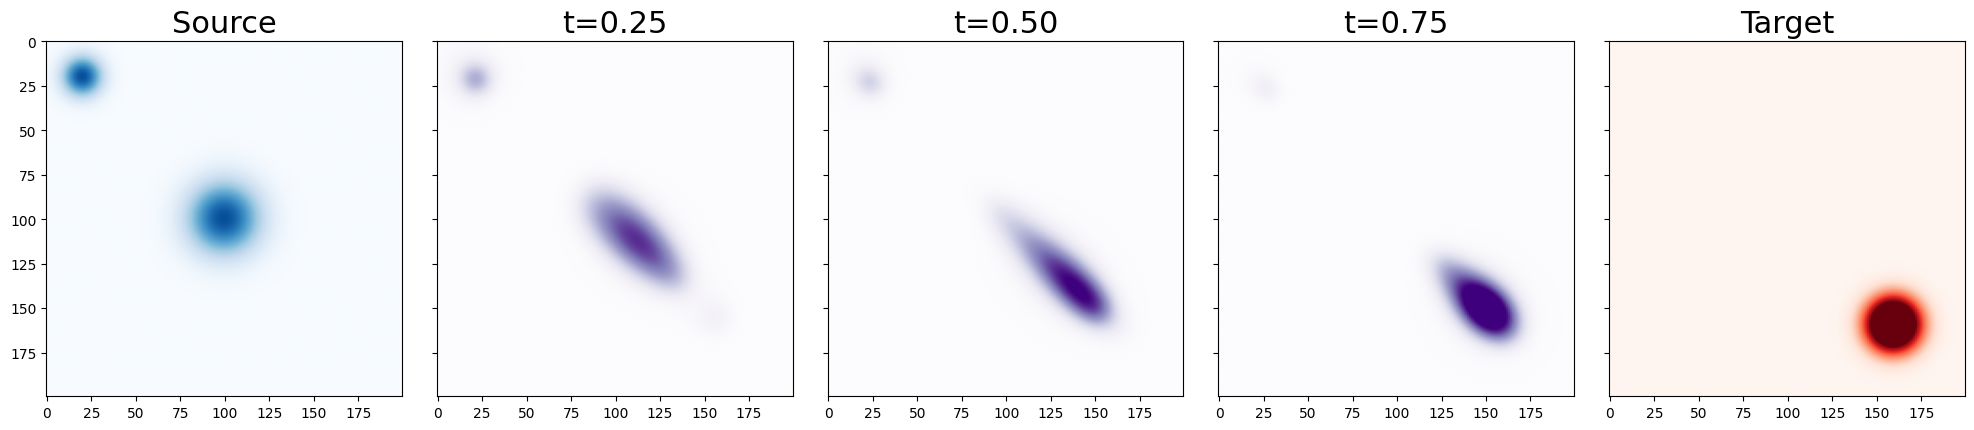

In [9]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,4), sharey=True)
ax1.imshow(f1.reshape((step,step)),cmap='Blues',vmin=vmin,vmax=vmax)
ax1.set_title('Source',fontsize=fs)
ax5.imshow(f2.reshape((step,step)),cmap='Reds',vmin=vmin,vmax=vmax)
ax5.set_title('Target',fontsize=fs)
ax2.imshow(barycenter1.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax2.set_title('t=0.25',fontsize=fs)
ax3.imshow(barycenter2.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax3.set_title('t=0.50',fontsize=fs)
ax4.imshow(barycenter3.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax4.set_title('t=0.75',fontsize=fs)
plt.tight_layout()
plt.savefig('img/bary_rho1_01.pdf', bbox_inches='tight')
plt.show()  

# USOT barycenter (assymetric $\rho_1/\rho_2$)

In [10]:
rho1= 1e-2
rho2= 100

barycenter1 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,rho2=rho2,weights=weights1,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter2 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,rho2=rho2,weights=weights2,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

barycenter3 = compute_barycenter_grid_MD_unbalanced(Xgrid, full_data, rho1=rho1,rho2=rho2,weights=weights3,
                                                    bar_iter=bar_iter, fw_iter = fw_iter, lr_bar=lr_bar, 
                                                    num_proj=num_proj, mode=mode)

Objective value 0.015459153801202774: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


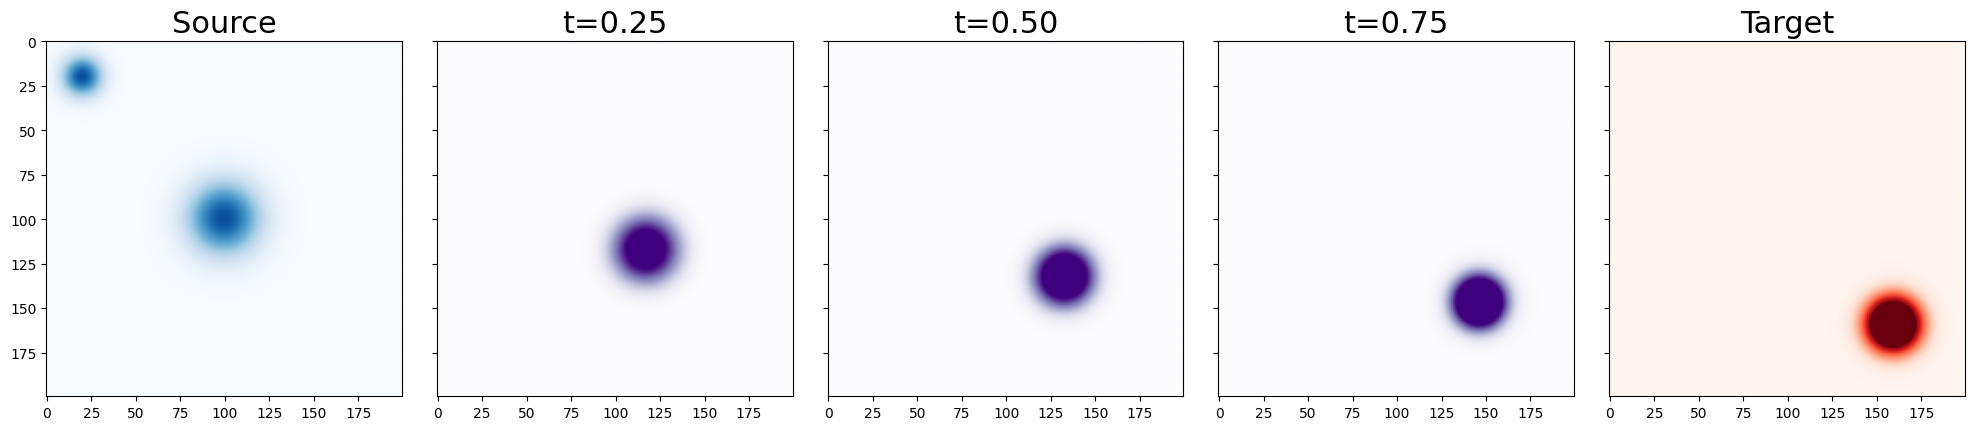

In [11]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,4), sharey=True)
ax1.imshow(f1.reshape((step,step)),cmap='Blues',vmin=vmin,vmax=vmax)
ax1.set_title('Source',fontsize=fs)
ax5.imshow(f2.reshape((step,step)),cmap='Reds',vmin=vmin,vmax=vmax)
ax5.set_title('Target',fontsize=fs)
ax2.imshow(barycenter1.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax2.set_title('t=0.25',fontsize=fs)
ax3.imshow(barycenter2.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax3.set_title('t=0.50',fontsize=fs)
ax4.imshow(barycenter3.clone().detach().cpu().numpy().reshape((step,step)),cmap='Purples',vmin=vmin,vmax=vmax)
ax4.set_title('t=0.75',fontsize=fs)
plt.tight_layout()
plt.savefig('img/bary_rho1_001_rho2_100.pdf', bbox_inches='tight')
plt.show()  